In [1]:
from __future__ import absolute_import, division, print_function

!pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print (device_name)

/device:GPU:0


In [0]:
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import pandas as pd
import time
import random
from collections import Counter
import math

In [3]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:
batch_size = 64
emb_size = 300
hidden_size = 1024
lr = 1e-3

In [0]:
train_en_path = '/content/drive/My Drive/Colab Notebooks/cs11747/data/para/train.en.txt' # train set
train_ja_path = '/content/drive/My Drive/Colab Notebooks/cs11747/data/para/train.ja.txt' # train set
dev_en_path = '/content/drive/My Drive/Colab Notebooks/cs11747/data/para/dev.en.txt' # dev set
dev_ja_path = '/content/drive/My Drive/Colab Notebooks/cs11747/data/para/dev.ja.txt' # dev set
test_en_path = '/content/drive/My Drive/Colab Notebooks/cs11747/data/para/test.en.txt' 
test_ja_path = '/content/drive/My Drive/Colab Notebooks/cs11747/data/para/test.ja.txt' 

In [0]:
def read_data(file):
    with open(file, "r") as f:
        data = []
        for line in f:
            words = line.lower().strip()
            words = '<start> ' + words + ' <end>'
            data.append(words)
        return data

In [0]:
train_en = read_data(train_en_path)
train_ja = read_data(train_ja_path)
dev_en = read_data(dev_en_path)
dev_ja = read_data(dev_ja_path)
test_en = read_data(test_en_path)
test_ja = read_data(test_ja_path)

In [0]:
tokenizer_en = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;=?@[\]^_`{|}~ ', oov_token='<unk>') 
tokenizer_en.fit_on_texts(train_en)
train_seq_en = tokenizer_en.texts_to_sequences(train_en)
dev_seq_en = tokenizer_en.texts_to_sequences(dev_en)
test_seq_en = tokenizer_en.texts_to_sequences(test_en)

In [9]:
w2i_en = tokenizer_en.word_index
i2w_en = dict([(value, key) for (key, value) in w2i_en.items()])
nwords_en = len(w2i_en)
print (nwords_en)

7007


In [0]:
tokenizer_ja = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;=?@[\]^_`{|}~ ', oov_token='<unk>') 
tokenizer_ja.fit_on_texts(train_ja)
train_seq_ja = tokenizer_ja.texts_to_sequences(train_ja)
dev_seq_ja = tokenizer_ja.texts_to_sequences(dev_ja)
test_seq_ja = tokenizer_ja.texts_to_sequences(test_ja)

In [11]:
w2i_ja = tokenizer_ja.word_index
i2w_ja = dict([(value, key) for (key, value) in w2i_ja.items()])
nwords_ja = len(w2i_ja)
print (nwords_ja)

8055


In [12]:
w2i_ja['<unk>']

1

In [0]:
def train_gen(batch_size=batch_size):
    i = 0
    while i<len(train_seq_en):
        if i+batch_size < len(train_seq_en):
            batch_en = tf.keras.preprocessing.sequence.pad_sequences(train_seq_en[i:i+batch_size], padding='post')
            batch_ja = tf.keras.preprocessing.sequence.pad_sequences(train_seq_ja[i:i+batch_size], padding='post')
        else:
            batch_en = tf.keras.preprocessing.sequence.pad_sequences(train_seq_en[i:], padding='post')
            batch_ja = tf.keras.preprocessing.sequence.pad_sequences(train_seq_ja[i:], padding='post')
        i += batch_size
        yield batch_en, batch_ja

In [0]:
def dev_gen(batch_size=batch_size):
    i = 0
    while i<len(dev_seq_en):
        if i+batch_size < len(dev_seq_en):
            batch_en = tf.keras.preprocessing.sequence.pad_sequences(dev_seq_en[i:i+batch_size], padding='post')
            batch_ja = tf.keras.preprocessing.sequence.pad_sequences(dev_seq_ja[i:i+batch_size], padding='post')
        else:
            batch_en = tf.keras.preprocessing.sequence.pad_sequences(dev_seq_en[i:], padding='post')
            batch_ja = tf.keras.preprocessing.sequence.pad_sequences(dev_seq_ja[i:], padding='post')
        i += batch_size
        yield batch_en, batch_ja

In [0]:
def test_gen(batch_size=batch_size):
    i = 0
    while i<len(test_seq_en):
        if i+batch_size < len(test_seq_en):
            batch_en = tf.keras.preprocessing.sequence.pad_sequences(test_seq_en[i:i+batch_size], padding='post')
        else:
            batch_en = tf.keras.preprocessing.sequence.pad_sequences(test_seq_en[i:], padding='post')
        i += batch_size
        yield batch_en

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, nwords, embed_size, hidden_size):
        super(Encoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(nwords+1, embed_size, trainable=True)
        self.gru = tf.keras.layers.GRU(hidden_size, 
                                       return_sequences=True, 
                                       return_state=True, 
                                       recurrent_initializer='glorot_uniform')

    def call(self, x):
        x = self.embedding(x)
        # passing all time steps to the GRU
        outputs, state = self.gru(x)

        return outputs, state

In [0]:
encoder = Encoder(nwords_en, emb_size, hidden_size)

In [0]:
class AdditiveAttention(tf.keras.Model):
    def __init__(self, units):
        super(AdditiveAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.v = tf.keras.layers.Dense(1)
        
    def call(self, query, keys):
        query = tf.expand_dims(self.W2(query), 1)
        score = self.v(tf.nn.tanh(self.W1(keys) + query)) #[batch, time, 1]
        score = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(keys * score, axis=1) #[batch, hidden]
        return context, score

In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, nwords, embed_size, hidden_size):
        super(Decoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(nwords+1, embed_size, trainable=True)
        self.gru = tf.keras.layers.GRU(hidden_size, 
                                       return_sequences=True, 
                                       return_state=True, 
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(nwords+1)
        self.attention = AdditiveAttention(hidden_size)

    def call(self, x, hidden, enc_outputs): # x:[batch, 1]
        x = self.embedding(x) #[batch, 1, emb]
        context, score = self.attention(hidden, enc_outputs)
        x = tf.concat([x, tf.expand_dims(context, axis=1)], axis=-1) #[batch, 1, emb+hidden]
        # passing one time step to the GRU
        output, state = self.gru(x, initial_state=hidden)
        output = tf.reshape(output, (-1, output.shape[2])) #[batch, hidden]
        x = self.fc(output)

        return x, state, score

In [0]:
decoder = Decoder(nwords_ja, emb_size, hidden_size)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [0]:
def train_step(src, tar):
    loss = 0  
    steps = tar.shape[1]
    with tf.GradientTape() as tape:
        enc_outputs, enc_hidden = encoder(src)
        dec_hidden = enc_hidden
        # Teacher forcing - feeding the target as the next input
        for t in range(steps-1):
            dec_input = tf.expand_dims(tar[:, t], 1)   
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_outputs)
            loss += loss_function(tar[:, t+1], predictions)

    batch_loss = loss / int(steps-1)
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
  
    return batch_loss

In [0]:
def eval_step(src, tar):
    loss = 0    
    enc_outputs, enc_hidden = encoder(src)
    dec_hidden = enc_hidden
    # Teacher forcing - feeding the target as the next input
    for t in range(tar.shape[1]-1):
        dec_input = tf.expand_dims(tar[:, t], 1)   
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_outputs)
        loss += loss_function(tar[:, t+1], predictions)

    batch_loss = loss / int(tar.shape[1]-1)
  
    return batch_loss

In [28]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    print ('Epoch {} start ...... '.format(epoch + 1))
    total_loss = 0
    batch = 0
    for src, tar in train_gen():
        batch_loss = train_step(src, tar)
        total_loss += batch_loss
        batch += 1

        if batch % 20 == 0:
            print('  ---- Batch {} Loss {:.4f}'.format(batch, batch_loss))
    
    # Evaluate on dev set
    dev_loss = 0
    batch_eval = 0
    for src, tar in dev_gen():
        batch_loss = eval_step(src, tar)
        dev_loss += batch_loss
        batch_eval += 1

    print('Epoch {} finished in {} seconds. Training loss {:.4f}. Evaluation loss {:.4f}.'.format(epoch + 1, time.time() - start, total_loss / batch, dev_loss / batch_eval))

Epoch 1 start ...... 
16 tf.Tensor(73.8307, shape=(), dtype=float32)
16 tf.Tensor(77.51991, shape=(), dtype=float32)
16 tf.Tensor(79.84814, shape=(), dtype=float32)
16 tf.Tensor(73.3677, shape=(), dtype=float32)
16 tf.Tensor(72.77487, shape=(), dtype=float32)
16 tf.Tensor(67.81688, shape=(), dtype=float32)
16 tf.Tensor(67.12236, shape=(), dtype=float32)
16 tf.Tensor(64.98551, shape=(), dtype=float32)
16 tf.Tensor(67.77779, shape=(), dtype=float32)
16 tf.Tensor(81.22999, shape=(), dtype=float32)
16 tf.Tensor(81.946785, shape=(), dtype=float32)


KeyboardInterrupt: ignored

In [0]:
def translate_step(src):
    enc_outputs, enc_hidden = encoder(src)
    dec_hidden = enc_hidden
    dec_input = tf.fill([src.shape[0], 1], w2i_ja['<start>'])
    results = ['<start> '] * src.shape[0]
    for t in range(30): 
        predictions, dec_hidden, score = decoder(dec_input, dec_hidden, enc_outputs)
        predicted_id = tf.argmax(predictions, axis=1).numpy()

        results = [r + i2w_ja.get(i, '<end>') + ' ' for (r, i) in zip(results, predicted_id)]
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims(predicted_id, 1)
    return results

In [0]:
def translate():
    i = 0
    for src in test_gen():
        sents = translate_step(src)
        for sent in sents:
            words = sent.split()[1:]
            s = ''
            for w in words:
                if w != '<end>':
                    s = s + w + ' '
                else:
                    break
            print (f'============= Sentence {i} =============')
            print (f'translated sentence: {s}')
            tar = ' '.join(test_ja[i].split()[1:-1])
            print (f'standard target sentence: {tar}')
            print (f'BLEU score is: {bleu(s, tar)}')
            i += 1

In [0]:
def bleu_stat(hypo, ref):
    h = hypo.strip().split()
    r = ref.strip().split()
    stat = [len(h), len(r)]
    for n in range(1, 5):
        h_ngram = Counter([tuple(h[i:i+n]) for i in range(len(h)+1-n)])
        r_ngram = Counter([tuple(r[i:i+n]) for i in range(len(r)+1-n)])
        denominator = sum(h_ngram.values())
        numerator = 0
        for g in h_ngram:
            c = min([h_ngram[g], r_ngram.get(g, 0)])
            numerator += c
        stat.append(numerator)
        stat.append(denominator)
    return stat

In [0]:
def bleu(trans, tar):
    stat = bleu_stat(trans, tar)
    if 0 in stat:
        return 0
    l = sum([math.log(n/d) for n, d in zip(stat[2::2], stat[3::2])]) / 4.0
    bp = math.exp(min([0, 1-stat[1]/stat[0]]))
    return bp * math.exp(l)

In [0]:
translate()

============= Sentence 0 =============
translated sentence: あなた の 尻目 は どれ で す か 。 
standard target sentence: 君 は １ 日 で それ が でき ま す か 。
BLEU score is: 0
============= Sentence 1 =============
translated sentence: 彼 は 私 に も 私 の 申し出 を きっぱり 断 っ た 。 
standard target sentence: 皮肉 な 笑い を 浮かべ て 彼 は 私 を 見つめ た 。
BLEU score is: 0
============= Sentence 2 =============
translated sentence: 今日 は 私 の もの で す 。 
standard target sentence: 私 たち の 出発 の 時間 が 差し迫 っ て い る 。
BLEU score is: 0
============= Sentence 3 =============
translated sentence: あなた の 尻目 は どれ で す か 。 
standard target sentence: あなた は 午後 何 を し た い で す か 。
BLEU score is: 0.236682065782701
============= Sentence 4 =============
translated sentence: あなた の 尻目 を あわせ よう と し て い る 。 
standard target sentence: いつ 仕事 が 終わ る 予定 で す か 。
BLEU score is: 0
============= Sentence 5 =============
translated sentence: ちょっと の 間 、 あなた の 家 に は 行 か な けれ ば な ら な い 。 
standard target sentence: 件 の 一 件 で メール を いただ き ありがとう ござ い ま し た 。
BLEU score is: 0
==========

In [0]:
def test_one(sent, show_attention=True):
    print (f'source sentence: {sent}')
    src = ['<start> ' + sent.lower().strip() + ' <end>']
    inp = tokenizer_en.texts_to_sequences(src)[0]
    len_inp = len(inp)
    len_tar = 2 * len_inp
    attention_plot = np.zeros((len_tar, len_inp))
    inp = tf.expand_dims(tf.convert_to_tensor(inp), axis=0) # [batch=1, time]
    
    enc_outputs, enc_hidden = encoder(inp)
    dec_hidden = enc_hidden
    dec_input = tf.fill([1, 1], w2i_ja['<start>'])
    results = ['<start> ']
    for t in range(len_tar): 
        predictions, dec_hidden, score = decoder(dec_input, dec_hidden, enc_outputs)
        score = tf.reshape(score, (-1, ))
        
        attention_plot[t] = score.numpy()
        predicted_id = tf.argmax(predictions, axis=1).numpy()

        results = [r + i2w_ja.get(i, '<end>') + ' ' for (r, i) in zip(results, predicted_id)]
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims(predicted_id, 1)
    words = results[0].split()[1:]
    s = ''
    for w in words:
        if w != '<end>':
            s = s + w + ' '
        else:
            break
    print (f'translated sentence: {s}')
    if show_attention:
        attention_plot = attention_plot[1:1+len(s.strip().split()), 1:-1]
        plot_attention(attention_plot, sent.lower().strip().split(), s.strip().split())

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels(['']+sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels(['']+predicted_sentence, fontdict=fontdict)

    plt.show()

source sentence: We do not want to work
translated sentence: 私 たち は 明日 の 午後 に は 勉強 を し な い 。 


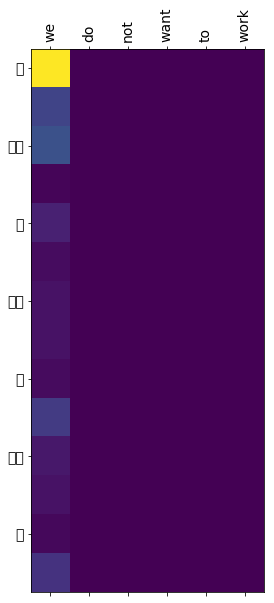

In [0]:
test_one('We do not want to work')